In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import yfinance as yf
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

In [ ]:
# Initialize Firebase
cred = credentials.Certificate('/content/drive/MyDrive/Predictions/financiaflutter-firebase-adminsdk-ajaw7-f515e50a59.json')
firebase_admin.initialize_app(cred)

ValueError: ignored

In [ ]:
crypto_currency = 'BNB'
against_currency = 'USD'

start = dt.datetime(2016,1,1)
end = dt.datetime.now()

data = yf.download('BNB-USD', start=start, end=end)

[*********************100%***********************]  1 of 1 completed


Prepare Data

In [ ]:
print(data.tail())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-07-30  242.582214  243.785721  240.925186  242.525986  242.525986   
2023-07-31  242.519592  244.202576  240.764450  241.120651  241.120651   
2023-08-01  241.128052  247.505020  238.530243  247.505020  247.505020   
2023-08-02  247.490311  248.511551  236.891769  240.494644  240.494644   
2023-08-07  243.010971  244.324249  241.957230  242.241211  242.241211   

                Volume  
Date                    
2023-07-30   425584373  
2023-07-31  1092564922  
2023-08-01   830645013  
2023-08-02   650256385  
2023-08-07   381459264  


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data['Close'].values.reshape(-1,1)

array([[  1.99076998],
       [  1.79683995],
       [  1.67047   ],
       ...,
       [247.50502014],
       [240.49464417],
       [242.24121094]])

In [ ]:
scalar= MinMaxScaler(feature_range=(0,1))
scaled_data =scalar.fit_transform(data['Close'].values.reshape(-1,1))
scaled_data.shape

(2094, 1)

In [ ]:
prediction_days = 60
future_day = 10

x_train, y_train=[], []

In [ ]:
for x in range(prediction_days, len(scaled_data)-future_day):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x+future_day, 0])


In [ ]:
 x_train[70]

array([0.01894177, 0.01992104, 0.02177471, 0.01862716, 0.01706421,
       0.01718124, 0.0179751 , 0.01738134, 0.01736621, 0.01741783,
       0.01784383, 0.01669323, 0.01444782, 0.01429104, 0.01187451,
       0.0120769 , 0.01222136, 0.01030636, 0.00770524, 0.01005452,
       0.00976699, 0.01050937, 0.01219285, 0.01148904, 0.01067166,
       0.01158768, 0.01108975, 0.01318687, 0.01397376, 0.01437499,
       0.01509839, 0.01363453, 0.01418824, 0.01245102, 0.01167419,
       0.01096701, 0.01213597, 0.01131986, 0.01162347, 0.01244777,
       0.01357149, 0.01324264, 0.0133487 , 0.0129261 , 0.01291587,
       0.01310899, 0.01275656, 0.01167951, 0.0111611 , 0.01008654,
       0.01009044, 0.00913904, 0.01003009, 0.00968431, 0.01276354,
       0.01104886, 0.01125633, 0.01127448, 0.01109118, 0.01103794])

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(2024, 60)

In [ ]:
y_train.shape

(2024,)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Create Neural Network

In [ ]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
64/64 [==============================] - 8s 60ms/step - loss: 0.0194
Epoch 2/25
64/64 [==============================] - 4s 69ms/step - loss: 0.0070
Epoch 3/25
64/64 [==============================] - 4s 65ms/step - loss: 0.0063
Epoch 4/25
64/64 [==============================] - 4s 61ms/step - loss: 0.0059
Epoch 5/25
64/64 [==============================] - 4s 68ms/step - loss: 0.0057
Epoch 6/25
64/64 [==============================] - 4s 67ms/step - loss: 0.0057
Epoch 7/25
64/64 [==============================] - 4s 60ms/step - loss: 0.0056
Epoch 8/25
64/64 [==============================] - 4s 65ms/step - loss: 0.0054
Epoch 9/25
64/64 [==============================] - 4s 70ms/step - loss: 0.0056
Epoch 10/25
64/64 [==============================] - 4s 61ms/step - loss: 0.0055
Epoch 11/25
64/64 [==============================] - 4s 62ms/step - loss: 0.0053
Epoch 12/25
64/64 [==============================] - 5s 72ms/step - loss: 0.0052
Epoch 13/25
64/64 [==================

Testing the model

In [ ]:
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = yf.download('BNB-USD', start=test_start, end=test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

[*********************100%***********************]  1 of 1 completed


In [ ]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scalar.fit_transform(model_inputs)

In [ ]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
x_test.shape

(1311, 60, 1)

In [ ]:
x_test

array([[[0.4014768 ],
        [0.40839011],
        [0.37521557],
        ...,
        [0.35737607],
        [0.34685469],
        [0.34947598]],

       [[0.40839011],
        [0.37521557],
        [0.37935344],
        ...,
        [0.34685469],
        [0.34947598],
        [0.00645812]],

       [[0.37521557],
        [0.37935344],
        [0.37720364],
        ...,
        [0.34947598],
        [0.00645812],
        [0.00546446]],

       ...,

       [[0.44730396],
        [0.44624786],
        [0.44390158],
        ...,
        [0.349979  ],
        [0.34990338],
        [0.34779422]],

       [[0.44624786],
        [0.44390158],
        [0.4014768 ],
        ...,
        [0.34990338],
        [0.34779422],
        [0.35737607]],

       [[0.44390158],
        [0.4014768 ],
        [0.40839011],
        ...,
        [0.34779422],
        [0.35737607],
        [0.34685469]]])

In [ ]:
prediction_prices = model.predict(x_test)
prediction_prices = scalar.inverse_transform(prediction_prices)

41/41 [==============================] - 1s 16ms/step


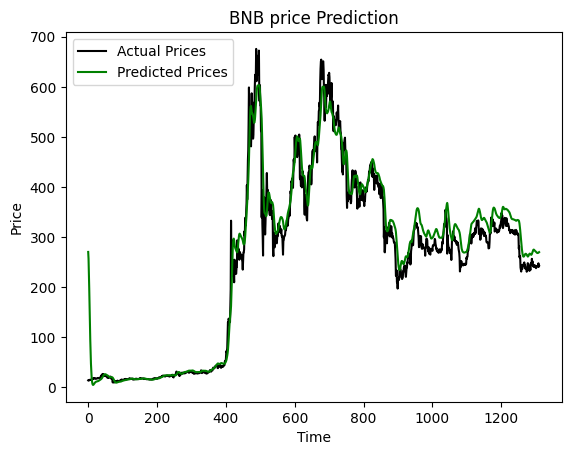

In [ ]:
plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title('BNB price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc = 'upper left')
plt.show()

# Predict next day

In [ ]:
real_data = [model_inputs[len(model_inputs)+1 - prediction_days:len(model_inputs) + 1, 0]]
real_data = np.array(real_data)


In [ ]:
real_data.shape

(1, 59)

In [ ]:
real_data = np.reshape(real_data, (real_data.shape[0],real_data.shape[1], 1))

In [ ]:
prediction = model.predict(real_data)
prediction = scalar.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 1s 775ms/step
[[270.2273]]


In [ ]:
# Save the prediction value to Firebase Firestore
db = firestore.client()
doc_ref = db.collection('predictioncrypto').document(crypto_currency)
doc_ref.set({
    'prediction': float(prediction[0][0])
})

update_time {
  seconds: 1691397931
  nanos: 381723000
}